In [1]:
def explore():
    # This Python 3 environment comes with many helpful analytics libraries installed
    # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
    # For example, here's several helpful packages to load
    
    import numpy as np # linear algebra
    import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
    from pathlib import Path
    
    # Input data files are available in the read-only "../input/" directory
    # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
    
    import os
    sortme = []
    for dirname, _, filenames in os.walk('/kaggle/input'):
        for filename in filenames:
            full_path = Path(dirname)/filename
            sortme.append(str(full_path))
            '''if full_path.suffix.lower().strip('.') in ['py', 'yaml', 'csv', 'bat'] or full_path.name == 'classes.txt':
                prefix = '/kaggle/input/synthetic-2-real-object-detection-challenge/Synthetic to Real Object Detection Challenge/'
                print(f'## [{str(full_path).removeprefix(prefix)}] ##')
                print(full_path.read_text())'''
            
    sortme.sort()
    for path in sortme:
        print(path)
    # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
    # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

#explore()

In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import torchvision
from torchvision.transforms import v2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path

import PIL
from pathlib import Path

from tqdm import tqdm

In [59]:
## Device agnostic code and set the image size to use
IMAGE_SIZE_SQUARE = 512
KAGGLE = False

if KAGGLE:
    torch_root_dir = Path("/kaggle/working/torch_modified_dataset/")
    root_data_dir = Path('./synthetic-2-real-object-detection-challenge/Synthetic to Real Object Detection Challenge/data/')
    root_dir = Path('./synthetic-2-real-object-detection-challenge/Synthetic to Real Object Detection Challenge/')
else:
    torch_root_dir = Path("/home/neko/working/cheerios/torch_modified_dataset/")
    root_data_dir = Path('/home/neko/working/cheerios/Synthetic to Real Object Detection Challenge/data/')
    root_dir = Path('./synthetic-2-real-object-detection-challenge/Synthetic to Real Object Detection Challenge/')

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_default_device(device)
print(f"Default device set to --> {device}")

Default device set to --> cuda


## Set root directories for each dataset

In [44]:
#root_data_dir = Path('/kaggle/input/synthetic-2-real-object-detection-challenge/Synthetic to Real Object Detection Challenge/data/')\

if KAGGLE:
    train_data_dir, eval_data_dir, test_data_dir = (root_data_dir / x for x in ['train', 'val', 'test'])
else:
    train_data_dir, eval_data_dir, test_data_dir = (root_data_dir / x for x in ['train', 'val', 'test'])
train_data_dir, eval_data_dir, test_data_dir

(PosixPath('/home/neko/working/cheerios/Synthetic to Real Object Detection Challenge/data/train'),
 PosixPath('/home/neko/working/cheerios/Synthetic to Real Object Detection Challenge/data/val'),
 PosixPath('/home/neko/working/cheerios/Synthetic to Real Object Detection Challenge/data/test'))

## Check for corrupted images

In [45]:
ok = 0
errors = []
image_extensions = {}
for data_dir in [train_data_dir, eval_data_dir, test_data_dir]:
    dataset_name = data_dir.stem
    image_extensions[dataset_name] = set()
    for image_path in tqdm(list((data_dir / 'images').iterdir()), desc=dataset_name):
        if image_path.suffix.lower() not in {'.png', '.jpg', '.jpeg'}:
            continue
        try:
            # assume the image to not be corrupted if pillow can load it
            PIL.Image.open(image_path).load()
            ok += 1
        except Exception as e:
            errors.append((image_path, e))
for image_path, e in errors:
    print(image_path)
    print(e)
    print()
print(f'Images loaded successfuly: {ok}. Images that couldn\'t be loaded: {len(errors)}.')

train:  17%|█▋        | 74/431 [00:03<00:18, 19.41it/s]


KeyboardInterrupt: 

In [46]:
# these functions don't care if the input is relative or absolute.
# if inputs are absolute, return values are absolute and
# if inputs are relative, return values are relative

def yolo_to_xy(x_center, y_center, w, h):
    xmin = x_center - w/2
    xmax = x_center + w/2
    ymin = y_center - h/2
    ymax = y_center + h/2
    
    return xmin, ymin, xmax, ymax

def xy_to_yolo(x1, y1, x2, y2):
    xmin = min(x1, x2)
    xmax = max(x1, x2)
    ymin = min(y1, y2)
    ymax = max(y1, y2)
    
    width = xmax - xmin
    height = ymax - ymin
    x_center = (xmin + xmax) / 2
    y_center = (ymin + ymax) / 2


    return (
        x_center,
        y_center,
        width,
        height
    )


#0 0.4231770833333333 0.4324074074074074 0.2140625 0.46296296296296297

# Since the function keeps everything within the same floating range, there~s gonna be some lost information 
x1, y1, x2, y2 = yolo_to_xy(0.4231770833333333, 0.4324074074074074, 0.2140625, 0.46296296296296297)
xy_to_yolo(x1, y1, x2, y2)

(0.4231770833333333,
 0.4324074074074074,
 0.21406249999999993,
 0.4629629629629629)

In [47]:
class CheeriosDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform_image=None, transform_image_bbox=None, target_transform=None):
        self.root_dir = Path(root_dir)
        self.image_dir = self.root_dir / 'images'
        self.label_dir = self.root_dir / 'labels'
        self.transform_image = transform_image
        self.transform_image_bbox = transform_image_bbox
        self.target_transform = target_transform
        self.image_file_paths = []
        self.data_pairs = []
        
        for image_path in self.image_dir.iterdir():
            if image_path.suffix.lower() not in {'.jpeg', '.jpg', '.png'}:
                continue  # ignore if it's not an image
            self.image_file_paths.append(image_path)
            
        self.image_file_paths.sort()


        # assign the corresponding label for each image, storing the assignments in data_pairs
        for image_path in self.image_file_paths:
            label_path = self.label_dir / image_path.with_suffix('.txt').name
            #print(label_path)
            text_content = label_path.read_text().strip() if label_path.is_file() else None
            all_labels = []
            if text_content:
                for line in text_content.splitlines():
                    _, center_x, center_y, width, height = map(float, line.strip().split())
                    all_labels.append([1, center_x, center_y, width, height])
                self.data_pairs.append((image_path, all_labels))
            else:
                self.data_pairs.append((image_path, []))

        # initialize cache to prevent loading the same file more than once
        self.image_cache = [None] * len(self.image_file_paths)

    def __len__(self):
        return len(self.data_pairs)

    def __getitem__(self, idx):
        image_path, label = self.data_pairs[idx]
        if self.image_cache[idx] is None:
            pilimg = PIL.Image.open(image_path).convert('RGB')
            image_tensor = v2.functional.pil_to_tensor(pilimg).type(torch.uint8)
            image = torchvision.tv_tensors.Image(image_tensor)
            self.image_cache[idx] = image
        else:
            image = self.image_cache[idx]

        orig_height, orig_width = image.shape[1:]

        # create a list of lists (for some reason using a tensor here throws a mysterious exception)
        # only create in case label is existent
        image = image.cpu()
        retlabel = torch.tensor([]) # for in case there is no label, it will just return an empty tensor
        if label != []:
            bboxes = []
            for label_line in label:
                _, cx_norm, cy_norm, w_norm, h_norm = label_line
                bboxes.append(
                    # convert everything to xyxy
                    list(yolo_to_xy(
                        (cx_norm * orig_width),
                        (cy_norm * orig_height),
                        (w_norm * orig_width),
                        (h_norm * orig_height)
                    ))
                )
    
            bboxes_tv = torchvision.tv_tensors.BoundingBoxes(
                bboxes,
                format='XYXY',
                canvas_size=image.shape[-2:]
            )

            # for cpu only operations with transform
            
            if self.transform_image_bbox:
                if bboxes:
                    image, bboxes_tv = self.transform_image_bbox(image, bboxes_tv)
                else:
                    image = self.transform_image_bbox(image)
            
            if self.transform_image:
                image = self.transform_image(image)
    
            if len(bboxes_tv) > 0:
                # convert the silly list of lists back into a tensor
                retlabel = torch.tensor([list(xy_to_yolo(*label_line)) for label_line in bboxes_tv])
                
            else:
                retlabel = torch.zeros((0, 4), dtype=torch.float32)
    
            if self.target_transform:
                retlabel = self.target_transform(retlabel)
        else:
            if self.transform_image_bbox:
                image = self.transform_image_bbox(image)
                    
            if self.transform_image:
                image = self.transform_image(image)
                
        image = image.cpu()
        return image, retlabel


## Basic EDA: check how many positives and negatives

In [48]:
from collections import Counter
train_dataset = CheeriosDataset(train_data_dir)
eval_dataset = CheeriosDataset(eval_data_dir)
test_dataset = CheeriosDataset(test_data_dir)
union = train_dataset.data_pairs #+ eval_dataset.data_pairs

c = Counter()
for _, label in union:  # avoid loading the images
    c[len(label)] += 1
print(f"Images with/wihout a cheerio box {c}")

Images with/wihout a cheerio box Counter({1: 424, 0: 7})


In [49]:
# transforms that only apply to the pixels themselves
transform_image = v2.Compose([
    v2.ToDtype(torch.float32, scale=True),
    v2.GaussianBlur(kernel_size=5, sigma=(0.001, 2.0)),
    v2.GaussianNoise(sigma=0.05),
    v2.ToDtype(torch.uint8, scale=True),
    v2.RandomChoice([
        v2.ColorJitter(
            brightness=0.8,
            contrast=0.8,
            saturation=0.8,
            hue=0.2
        ),
        v2.RandomPosterize(bits=3),
        v2.RandomSolarize(threshold=0.5),
    ]),
    v2.JPEG(quality=(50, 100)),
])

# transforms that apply to the pixels and/or the bounding boxes
transform_image_bbox =  v2.Compose([
    v2.Resize((IMAGE_SIZE_SQUARE, IMAGE_SIZE_SQUARE)),
    v2.RandomHorizontalFlip(0.2),
    v2.RandomVerticalFlip(0.2),
    v2.RandomAffine(
        degrees=(-60, 60),
        translate=(0.3, 0.3),
        scale=(0.5, 1.5),
        shear=(-30, 30)
    ),

    # using SanitizeBoundingBoxes here is scary because we only have one bbox per datapoint
])


In [50]:
train_dataset = CheeriosDataset(train_data_dir, transform_image, transform_image_bbox)
train_dataset_no_transforms = CheeriosDataset(train_data_dir, None, None)
eval_dataset = CheeriosDataset(eval_data_dir, transform_image, transform_image_bbox)

## Visualize a random image + bbox after being transformed

tensor([[[294.1834, 352.8766,  79.9583, 318.2467]]], device='cuda:0')
tensor([294.1834, 352.8766,  79.9583, 318.2467], device='cuda:0')


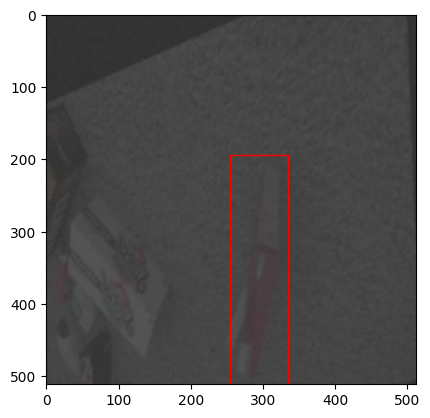

In [12]:
from matplotlib.patches import Rectangle

dl = torch.utils.data.DataLoader(train_dataset, shuffle=1, generator=torch.Generator(device=device))

image, label = next(iter(dl))

plt.imshow(torch.permute(image.squeeze(), (1, 2, 0)))
ax = plt.gca()
print(label)
for bbox in label[0]:
    print(bbox)
    # to make things maybe simpler, `label` doesn't contain the class,
    # it's just the bounding box in centerx, centery, width, height format.
    # IMPORTANT: the coordinates of the bounding box are ABSOLUTE. to convert to relative
    # do `bbox = bbox/IMAGE_SIZE_SQUARE`
    bbox = bbox.cpu()
    ax.add_patch(Rectangle((
        bbox[0] - bbox[2]/2,
        bbox[1] - bbox[3]/2
    ), bbox[2], bbox[3],linewidth=1,edgecolor='r',facecolor='none'))

# Visualize an image both with and without the transformation

/home/neko/.conda/envs/AIdev/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  return func(*args, **kwargs)


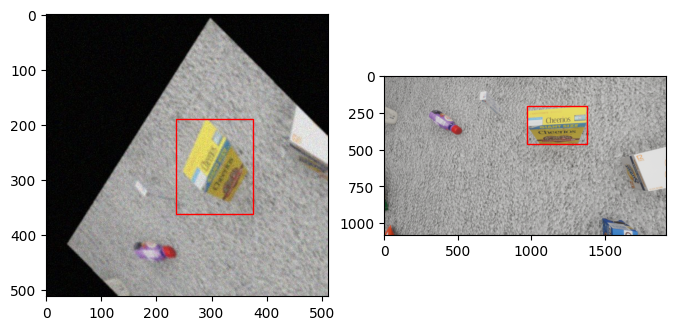

In [51]:
from matplotlib.patches import Rectangle

dataloaders = [torch.utils.data.DataLoader(train_dataset, shuffle=0, generator=torch.Generator(device=device)), torch.utils.data.DataLoader(train_dataset_no_transforms, shuffle=0, generator=torch.Generator(device=device))]

labels = []
fig, axis = plt.subplots(1, 2, figsize=(8, 16))
for ax_idx in range(2):
    image, label = next(iter(dataloaders[ax_idx]))
    labels.append(label)
    axis[ax_idx].imshow(torch.permute(image.squeeze(), (1, 2, 0)))
ax = plt.gca()
for idx, label in enumerate(labels):
    for bbox in label[0]:
        # to make things maybe simpler, `label` doesn't contain the class,
        # it's just the bounding box in centerx, centery, width, height format.
        # IMPORTANT: the coordinates of the bounding box are ABSOLUTE. to convert to relative
        # do `bbox = bbox/IMAGE_SIZE_SQUARE`
        bbox = bbox.cpu()
        axis[idx].add_patch(Rectangle((
            bbox[0] - bbox[2]/2,
            bbox[1] - bbox[3]/2
        ), bbox[2], bbox[3],linewidth=1,edgecolor='r',facecolor='none'))

# Work with Yolo model

In [14]:
pip install git+https://github.com/ultralytics/ultralytics.git@main

  Cloning https://github.com/ultralytics/ultralytics.git (to revision main) to /tmp/pip-req-build-7y7j_6dp
  Running command git clone --filter=blob:none --quiet https://github.com/ultralytics/ultralytics.git /tmp/pip-req-build-7y7j_6dp
  Resolved https://github.com/ultralytics/ultralytics.git to commit 93107d1d807eff2a6e3be2944e21525395024736
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 23.6 MB/s eta 0:00:00m eta 0:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 24.1 MB/s eta 0:00:00m eta 0:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 751.2/751.2 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.6/37.6 MB 24.2 MB/s eta 0:00:00m eta 0:00:010:01:01
  Created wheel for ultralytics: filename=ultralytics-8.3.105-py3-none-any.whl size=972924 sha256=5711c45da14fdbd2ff506ea1a77b7c7bad245a6f7eb0

In [15]:
from ultralytics import YOLO
import cv2

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/home/neko/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [16]:
model = YOLO("yolov8n-seg.pt")

100%|██████████| 6.74M/6.74M [00:00<00:00, 65.5MB/s]


In [18]:
!mkdir ./torch_modified_dataset

# Adding more data to dataset using pytorch

In [52]:
# redefining datasets for clarity
train_dataset = CheeriosDataset(train_data_dir, transform_image, transform_image_bbox)
test_dataset = CheeriosDataset(test_data_dir, transform_image, transform_image_bbox)
eval_dataset = CheeriosDataset(eval_data_dir, transform_image, transform_image_bbox)


# test has no labels since it's for submission
train_dataloader = DataLoader(train_dataset, shuffle=False, generator=torch.Generator(device=device))
test_dataloader = DataLoader(test_dataset, shuffle=False, generator=torch.Generator(device=device))
eval_dataloader = DataLoader(eval_dataset, shuffle=False, generator=torch.Generator(device=device))
dataloaders = {"train": train_dataloader, "val": eval_dataloader}

In [32]:
#!mkdir -p /kaggle/working/torch_modified_dataset/data/train/images
#!mkdir -p /kaggle/working/torch_modified_dataset/data/train/labels

!mkdir -p /home/neko/working/cheerios/torch_modified_dataset/data/train/images
!mkdir -p /home/neko/working/cheerios/torch_modified_dataset/data/train/labels

#!mkdir -p /kaggle/working/torch_modified_dataset/data/test/images
#!mkdir -p /kaggle/working/torch_modified_dataset/data/test/labels

!mkdir -p /home/neko/working/cheerios/torch_modified_dataset/data/test/images
!mkdir -p /home/neko/working/cheerios/torch_modified_dataset/data/test/labels

#!mkdir -p /kaggle/working/torch_modified_dataset/data/val/images
#!mkdir -p /kaggle/working/torch_modified_dataset/data/val/labels

!mkdir -p /home/neko/working/cheerios/torch_modified_dataset/data/val/images
!mkdir -p /home/neko/working/cheerios/torch_modified_dataset/data/val/labels

#!rsync -aP --exclude=data "/kaggle/input/synthetic-2-real-object-detection-challenge/Synthetic to Real Object Detection Challenge/"* /kaggle/working/torch_modified_dataset
!rsync -aP --exclude=data "/home/neko/working/cheerios/Synthetic to Real Object Detection Challenge/"* /home/neko/working/cheerios/torch_modified_dataset/

sending incremental file list
classes.txt
             10 100%    0.00kB/s    0:00:00 (xfr#1, to-chk=9/10)
convert_preds_to_csv.py
          3,868 100%    3.69MB/s    0:00:00 (xfr#2, to-chk=8/10)
predict.py
          3,734 100%    3.56MB/s    0:00:00 (xfr#3, to-chk=7/10)
sample_submission.csv
         14,556 100%   13.88MB/s    0:00:00 (xfr#4, to-chk=6/10)
train.py
          5,647 100%    5.39MB/s    0:00:00 (xfr#5, to-chk=5/10)
yolo_params.yaml
            283 100%  276.37kB/s    0:00:00 (xfr#6, to-chk=4/10)
ENV_SETUP/
ENV_SETUP/create_env.bat
            334 100%  326.17kB/s    0:00:00 (xfr#7, to-chk=2/10)
ENV_SETUP/install_packages.bat
          1,059 100%    1.01MB/s    0:00:00 (xfr#8, to-chk=1/10)
ENV_SETUP/setup_env.bat
            245 100%  239.26kB/s    0:00:00 (xfr#9, to-chk=0/10)


In [60]:
for k, dl in dataloaders.items():
    print(f"{root_data_dir}/{k}")
    for idx, (image, label) in tqdm(enumerate(dl)):
        #PIL.Image.fromarray(image.squeeze().cpu().numpy()).save(f"./{k}_{idx}")
        torchvision.utils.save_image(image.squeeze()/255, f"{torch_root_dir}/data/{k}/images/{k}_{idx}.png")
        if label.nelement() != 0:
            # cat to add 0 for the class
            label = torch.cat([torch.tensor([0]), (label.squeeze()/IMAGE_SIZE_SQUARE)]).cpu().numpy().astype(np.double)
        else:
            if k != "test":
                label = label.squeeze().cpu().numpy()
        with open(f"{torch_root_dir}/data/{k}/labels/{k}_{idx}.txt", "w") as f:
            f.write(" ".join(str(x) for x in label))
            f.close()

/home/neko/working/cheerios/Synthetic to Real Object Detection Challenge/data/train


0it [00:00, ?it/s]

/home/neko/.conda/envs/AIdev/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  return func(*args, **kwargs)
23it [00:02,  8.78it/s]


KeyboardInterrupt: 

In [37]:
#!cp -rf "/kaggle/input/synthetic-2-real-object-detection-challenge/Synthetic to Real Object Detection Challenge/data/train/images/"* /kaggle/working/torch_modified_dataset/data/train/images
#!cp -rf "/kaggle/input/synthetic-2-real-object-detection-challenge/Synthetic to Real Object Detection Challenge/data/test/images/"* /kaggle/working/torch_modified_dataset/data/test/images
#!cp -rf "/kaggle/input/synthetic-2-real-object-detection-challenge/Synthetic to Real Object Detection Challenge/data/val/images/"* /kaggle/working/torch_modified_dataset/data/val/images
!cp -rf "/home/neko/working/cheerios/Synthetic to Real Object Detection Challenge/data/train/images/"* /home/neko/working/cheerios/torch_modified_dataset/data/train/images
!cp -rf "/home/neko/working/cheerios/Synthetic to Real Object Detection Challenge/data/test/images/"* /home/neko/working/cheerios/torch_modified_dataset/data/test/images
!cp -rf "/home/neko/working/cheerios/Synthetic to Real Object Detection Challenge/data/val/images"* /home/neko/working/cheerios/torch_modified_dataset/data/val/images

#!cp -rf "/kaggle/input/synthetic-2-real-object-detection-challenge/Synthetic to Real Object Detection Challenge/data/train/labels/"* /kaggle/working/torch_modified_dataset/data/train/labels
#!cp -rf "/kaggle/input/synthetic-2-real-object-detection-challenge/Synthetic to Real Object Detection Challenge/data/val/labels/"* /kaggle/working/torch_modified_dataset/data/val/labels

!cp -rf "/home/neko/working/cheerios/Synthetic to Real Object Detection Challenge/data/train/labels/"* /home/neko/working/cheerios/torch_modified_dataset/data/train/labels
!cp -rf "/home/neko/working/cheerios/Synthetic to Real Object Detection Challenge/data/val/labels/"* /home/neko/working/cheerios/torch_modified_dataset/data/val/labels


# Edit yaml for yolo params

In [62]:
yaml_text = f"""
# Dataset paths

train: {torch_root_dir}/data/train/images/  # Path to training images

val: {torch_root_dir}/data/val/images/      # Path to validation images

test: {torch_root_dir}/data/train/images/    # Path to test images



# Class information

nc: 1                     # Number of classes

names: ['cheerios']       # Class names
"""

with open (f"{torch_root_dir}/yolo_params.yaml", "w") as f:
    f.write(yaml_text)

# Reset default device for YOLO
- YOLO dataloaders don't use gpu by default (no cuda generators), thus they might throw out error while trying to use the dataloader

In [63]:
torch.set_default_device("cpu")

In [64]:
# get proper model
model = YOLO(model="yolov8n.pt")

In [65]:
# if this goes bad, dont change image size neither bbox, yolo can take care of it by itself
epochs = 10
model.train(
    data=f"{torch_root_dir}/yolo_params.yaml",
    epochs=epochs,
    lr0=0.0005,
    lrf=0.005,
    patience=int(epochs/20),
    save=True,
    batch=16,
    workers=12,
    imgsz=IMAGE_SIZE_SQUARE,
    device=device
)

# num of workers based on my own cpu

Ultralytics 8.3.105 🚀 Python-3.10.16 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3060, 11918MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/home/neko/working/cheerios/torch_modified_dataset/yolo_params.yaml, epochs=10, time=None, patience=0, batch=16, imgsz=512, save=True, save_period=-1, cache=False, device=cuda, workers=12, project=None, name=train4, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_l

100%|██████████| 755k/755k [00:00<00:00, 33.4MB/s]

Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

Model summary: 129 layers, 3,011,043 parameters, 3,011,027 gradients, 8.2 GFLOPs

Transferred 319/355 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...


100%|██████████| 5.35M/5.35M [00:00<00:00, 16.1MB/s]
/home/neko/.conda/envs/AIdev/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  return func(*args, **kwargs)


AMP: checks passed ✅


train: Scanning /home/neko/working/cheerios/torch_modified_dataset/data/train/labels... 862 images, 14 backgrounds, 0 corrupt: 100%|██████████| 862/862 [00:46<00:00, 18.60it/s]


train: New cache created: /home/neko/working/cheerios/torch_modified_dataset/data/train/labels.cache


val: Scanning /home/neko/working/cheerios/torch_modified_dataset/data/val/images/labels... 69 images, 70 backgrounds, 0 corrupt: 100%|██████████| 138/138 [00:13<00:00,  9.94it/s]

val: New cache created: /home/neko/working/cheerios/torch_modified_dataset/data/val/images/labels.cache


Plotting labels to runs/detect/train4/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.0005' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 512 train, 512 val
Using 12 dataloader workers
Logging results to runs/detect/train4
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/54 [00:00<?, ?it/s]/home/neko/.conda/envs/AIdev/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  return func(*args, **kwargs)
       1/10       4.2G      1.255      2.712      1.332         13        512: 100%|██████████| 54/54 [01:09<00:00,  1.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/5 [00:00

                   all        138         68      0.466     0.0773      0.218      0.107

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/54 [00:00<?, ?it/s]/home/neko/.conda/envs/AIdev/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  return func(*args, **kwargs)
       2/10      4.47G      1.345      1.984      1.348         12        512: 100%|██████████| 54/54 [00:25<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/5 [00:00

                   all        138         68      0.193      0.235      0.121     0.0445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/54 [00:00<?, ?it/s]/home/neko/.conda/envs/AIdev/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  return func(*args, **kwargs)
       3/10      4.49G      1.397      1.751      1.416         14        512: 100%|██████████| 54/54 [00:05<00:00, 10.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/5 [00:00

                   all        138         68      0.208      0.485      0.181     0.0778



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/54 [00:00<?, ?it/s]/home/neko/.conda/envs/AIdev/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  return func(*args, **kwargs)
       4/10       4.5G       1.32      1.473      1.384         14        512: 100%|██████████| 54/54 [00:05<00:00, 10.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/5 [00:00

                   all        138         68      0.317      0.647      0.269      0.124



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/54 [00:00<?, ?it/s]/home/neko/.conda/envs/AIdev/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  return func(*args, **kwargs)
       5/10      4.52G      1.285      1.284      1.336         14        512: 100%|██████████| 54/54 [00:05<00:00, 10.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/5 [00:00

                   all        138         68      0.308      0.701      0.285      0.139



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/54 [00:00<?, ?it/s]/home/neko/.conda/envs/AIdev/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  return func(*args, **kwargs)
       6/10      4.54G      1.224      1.133      1.288         13        512: 100%|██████████| 54/54 [00:05<00:00, 10.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/5 [00:00

                   all        138         68      0.352      0.676      0.317       0.16



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/54 [00:00<?, ?it/s]/home/neko/.conda/envs/AIdev/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  return func(*args, **kwargs)
       7/10      4.55G      1.155      1.035      1.248         14        512: 100%|██████████| 54/54 [00:05<00:00, 10.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/5 [00:00

                   all        138         68      0.369      0.838      0.368      0.196



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/54 [00:00<?, ?it/s]/home/neko/.conda/envs/AIdev/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  return func(*args, **kwargs)
       8/10      4.57G      1.106     0.9403      1.227         13        512: 100%|██████████| 54/54 [00:05<00:00, 10.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/5 [00:00

                   all        138         68      0.387      0.809      0.361      0.204



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/54 [00:00<?, ?it/s]/home/neko/.conda/envs/AIdev/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  return func(*args, **kwargs)
       9/10      4.59G      1.015     0.8502      1.192         14        512: 100%|██████████| 54/54 [00:05<00:00, 10.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/5 [00:00

                   all        138         68      0.426      0.838      0.404      0.224



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/54 [00:00<?, ?it/s]/home/neko/.conda/envs/AIdev/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  return func(*args, **kwargs)
      10/10      4.61G     0.9313     0.7707      1.135         14        512: 100%|██████████| 54/54 [00:05<00:00, 10.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/5 [00:00

                   all        138         68      0.418      0.853      0.409      0.223



10 epochs completed in 0.043 hours.
Optimizer stripped from runs/detect/train4/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train4/weights/best.pt, 6.2MB

Validating runs/detect/train4/weights/best.pt...
Ultralytics 8.3.105 🚀 Python-3.10.16 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3060, 11918MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


/home/neko/.conda/envs/AIdev/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:217.)
  return func(*args, **kwargs)
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:00<00:00,  6.69it/s]


                   all        138         68      0.426      0.838      0.404      0.224
Speed: 0.2ms preprocess, 1.0ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to runs/detect/train4


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7adbadc9b580>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

# Test on a test image

In [66]:
model.names

{0: 'cheerios'}

# Small sanity check for the model
- check if it can pred the bbox for any of the images; if cannot, must train in a different way (broken shit)

In [ ]:
def plot_bbox(img_path: str, bbox):
    print(bbox)
    bbox = [bbox[i]*512 for i in range(len(bbox))]
    ax = plt.gca()
    ax.imshow(PIL.Image.open(img_path))

    print(bbox[0])
    ax.add_patch(Rectangle((
        bbox[0] - bbox[2]/2,
        bbox[1] - bbox[3]/2
    ), bbox[2], bbox[3],linewidth=3,edgecolor='r',facecolor='none'))
    plt.show()

#plot_bbox("/kaggle/input/synthetic-2-real-object-detection-challenge/Synthetic to Real Object Detection Challenge/data/val/images/000000003.png", bbox=yolo_to_xy(0.4231770833333333, 0.4324074074074074, 0.2140625, 0.46296296296296297))

In [71]:
import glob

In [ ]:
path = glob.glob(f"{torch_root_dir}/data/train/images/*")
def pred_on_image(model, idx):
    image = cv2.imread(path[idx])
    preds = model.predict(image, conf=0.5, verbose=False)
    for pred in preds:
        bbox = pred.boxes.data.cpu().squeeze().numpy()
        #print("bbox --> ", bbox)
        print(pred.boxes)
        
        #plot_bbox(path[idx], [0.6169270833333333, 0.6472222222222223, 0.11822916666666666, 0.12962962962962962])
        #cv2.polylines(image, bbox, isClosed=True, color=(255, 0, 0))

pred_on_image(model=model, idx=0)

ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.], device='cuda:0')
conf: tensor([0.7273], device='cuda:0')
data: tensor([[7.2506e+02, 8.1785e+02, 1.0433e+03, 9.1469e+02, 7.2728e-01, 0.0000e+00]], device='cuda:0')
id: None
is_track: False
orig_shape: (1080, 1920)
shape: torch.Size([1, 6])
xywh: tensor([[884.1668, 866.2733, 318.2135,  96.8421]], device='cuda:0')
xywhn: tensor([[0.4605, 0.8021, 0.1657, 0.0897]], device='cuda:0')
xyxy: tensor([[ 725.0601,  817.8522, 1043.2736,  914.6943]], device='cuda:0')
xyxyn: tensor([[0.3776, 0.7573, 0.5434, 0.8469]], device='cuda:0')
